<a href="https://colab.research.google.com/github/Yakagi17/DTWS_2_UII/blob/master/EDA_vehicles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![picture](https://drive.google.com/uc?id=1-xuFvbmPE2Y8fTaRaBblI4ghFmRfG7Bs)

#Workshop Data Exploration and Visualization
##Sesi 1: Data Exploration
##lizda.iswari@uii.ac.id

![picture](https://drive.google.com/uc?id=1OjR20vnoB-fSJLGST9rBspVaubZwt2Lp)

#Apakah Exploratory Data Analysis (EDA)?

Jika ada teman Anda mengajak nonton sebuah film ke bioskop, film yang belum pernah Anda dengar sebelumnya!

Kira-kira pertanyaan apakah yang terpikir oleh Anda?

Mungkin Anda akan bertanya:
*   Cerita atau genrenya tentang apa?
*   Siapa pemainnya?
*   Apakah ada trailernya?
*   Mungkin Anda juga akan memeriksa rating dan review film tersebut.

Secara singkat, EDA adalah...

“*Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations*”[1]

#Dimanakah posisi EDA dalam Data Science?

![picture](https://drive.google.com/uc?id=14O5GQpryscKD5wvycnlzfvNI_4P0D1fZ)

## Studi Kasus: Vehicle Fuel Economy Data Set

Sumber data: http://bit.ly/ddl-cars

Dalam workshop kali ini, kita akan mengeksplorasi data ekonomi bahan bakar kendaraan (*vehicle fuel economy*). 

Data bersumber dari hasil pengujian kendaraan yang dilakukan di *National Vehicle Agency* dan Laboratorium Emisi Bahan Bakar, Badan Perlindungan Lingkungan (*Environmental Protection Agency*) Amerika Serikat di Ann Arbor, Michigan. Adapun kendaraan yang dilibatkan merupakan kendaraan dari produsen yang berada dalam pengawasan EPA.

Ukuran data cukup besar (16MB) sehingga didistribusikan dalam format zipfile. Langkah pertama, kita harus mengunduh data dan untuk itu dibutuhkan sejumlah software library, seperti os, zipfile dan request.

In [0]:
import os
import zipfile
import requests


Unduh data dan simpan ke komputer masing-masing.

In [0]:
def download_data(url, name, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)
    response = requests.get(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)
    z = zipfile.ZipFile(os.path.join(path, 'vehicles.zip'))
    z.extractall(path)
VEHICLES = 'http://bit.ly/ddl-cars'
download_data(VEHICLES, 'vehicles.zip')

Selanjutnya, kita akan memanggil dan mengolah data tersebut menggunakan software **Panda**. 

Panda adalah sebuah pustaka perangkat lunak yang ditulis untuk bahasa pemrograman Python. Umumnya Panda digunakan untuk memanipulasi dan analisis data, terutama data dalam tabel numerik dan data time series (deret waktu).

In [0]:
import pandas as pd
path = 'data'
vehicles = pd.read_csv(os.path.join(path, 'vehicles.csv'))


##Data Preview
Mari kita periksa struktur data vehicle tersebut. Berapakah jumlah kolom dan entries yang dimiliki oleh data tersebut?

Kolom berasosiasi dengan **atribute** atau karakteristik data, sedangkan entries disebut juga sebagai **obyek** data dan divisualisasikan sebagai baris dalam tabel.

In [0]:
vehicles.info()

Sekarang mari kita lihat isi data *vehicles* untuk 5 obyek teratas.

In [0]:
vehicles.head()

#Identifikasi Data

Terdapat sejumlah informasi umum yang terdapat di dalam data set tersebut:


*   Vehicle attributes information
*   Vehicle manufacturer information
*   Engine information
*   Fuel information (such as fuel efficiency, fuel type, and fuel cost)
*   Transmission information
*   Drive axle information


#Mari kita mulai EDA!

## Langkah 1 - Data Cleaning
Di tahap ini kita akan pre-processing data yang meliputi:


*   Memilih attributes yang akan diolah.
*   Memilih obyek yang akan diolah, yaitu kendaraan keluaran sebelum tahun 2017 akan dihapus.
*   Menghapus data yang terduplikat.
*   Mengurutkan data berdasarkan attribute *make, model*, dan *year*.

In [0]:
select_columns = ['make', 'model', 'year', 'displ', 'cylinders', 'trany', 'drive', 'VClass','fuelType','barrels08', 'city08', 'highway08', 'comb08', 'co2TailpipeGpm', 'fuelCost08']
vehicles = vehicles[select_columns][vehicles.year <= 2016].drop_duplicates().dropna()
vehicles = vehicles.sort_values(['make', 'model', 'year'])

Sekarang kita hanya akan bekerja dengan 15 attributes data. 

In [0]:
vehicles.info()

Mengubah nama kolom menjadi nama yang lebih intuitif.

In [0]:
vehicles.columns = ['Make','Model','Year','Engine Displacement','Cylinders',
                    'Transmission','Drivetrain','Vehicle Class','Fuel Type',
                    'Fuel Barrels/Year','City MPG','Highway MPG','Combined MPG',
                    'CO2 Emission Grams/Mile','Fuel Cost/Year']

In [0]:
vehicles.info()

##Langkah 2 - Data Categorization

Mari kita periksa sebaran nilai data untuk tiap kolom.

In [0]:
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))
unique_col_values(vehicles)

Berdasarkan output di atas, dapat dilihat sejumlah kolom bertipe numerik (int64 dan float64) dan beberapa diantara bertipe object. Tipe object menyatakan bahwa kolom tersebut memiliki nilai kategori di dalamnya.

Untuk saat ini, mari kita fokus terhadap 5 kolom yang bertipe category/object:

1.   Make: 126 unique values
2.   Model: 3,491 unique values
3.   Transmission: 43 unique values
4.   Drivetrain: 7 unique values
5.   Vehicle Class: 34 unique values

##a. Aggregasi Data Bertipe Category

Untuk memperoleh summary data yang bertipe category, kita akan menerapkan konsep data aggregation. Menurut penelitian, umumnya manusia hanya mampu mengelola 1-7 perbedaan di dalam short-term working memory-nya[2]. Padahal kalau kita lihat, 4 kolom di atas memiliki jumlah variasi kategori yang sangat besar.

Untuk itu kita akan mengagregasi/menggabungkan sejumlah kategori ke level yang lebih umum (higher level categories). Misal, data kendaraan bisa dikelompokkan berdasarkan merk, model, maupun tahun pembuatan.

Umumnya, agregasi data ke higher-level categories ini dilakukan berdasarkan kombinasi sejumlah kategori yang ada, maupun didasarkan atas pengetahuan yang telah dimiliki sebelumnya.

###Aggregating Kolom Transmission

Kolom Transmission memiliki 43 jenis kategori. Seperti kita ketahui, umumnya dikenal 2 jenis transmisi mesin, yaitu **Automatic** or **Manual**.

![picture](https://drive.google.com/uc?id=11B9zv600jboxXXE1RjgZDUHD40AWwt3s)

In [0]:
AUTOMATIC = "Automatic"
MANUAL = "Manual"
vehicles.loc[vehicles['Transmission'].str.startswith('A'),
             'Transmission Type'] = AUTOMATIC
vehicles.loc[vehicles['Transmission'].str.startswith('M'),
             'Transmission Type'] = MANUAL

In [0]:
vehicles['Transmission Type'].unique()

###Aggregating Kolom Vehicle Class

Untuk Vehicle Class terdapat 34 jenis kategori, di sini akan kita atur agar kolom tersebut hanya memiliki 8 nilai saja.

![picture](https://drive.google.com/uc?id=19bSG21zgmT9SWWgheUEhZoZC2O7vo7ur)

In [0]:
small = ['Compact Cars','Subcompact Cars','Two Seaters','Minicompact Cars']
midsize = ['Midsize Cars']
large = ['Large Cars']
vehicles.loc[vehicles['Vehicle Class'].isin(small), 
             'Vehicle Category'] = 'Small Cars'
vehicles.loc[vehicles['Vehicle Class'].isin(midsize), 
             'Vehicle Category'] = 'Midsize Cars'
vehicles.loc[vehicles['Vehicle Class'].isin(large), 
             'Vehicle Category'] = 'Large Cars'
vehicles.loc[vehicles['Vehicle Class'].str.contains('Station'), 
             'Vehicle Category'] = 'Station Wagons'
vehicles.loc[vehicles['Vehicle Class'].str.contains('Truck'), 
             'Vehicle Category'] = 'Pickup Trucks'
vehicles.loc[vehicles['Vehicle Class'].str.contains('Special Purpose'), 
             'Vehicle Category'] = 'Special Purpose'
vehicles.loc[vehicles['Vehicle Class'].str.contains('Sport Utility'), 
             'Vehicle Category'] = 'Sport Utility'
vehicles.loc[(vehicles['Vehicle Class'].str.lower().str.contains('van')),
             'Vehicle Category'] = 'Vans & Minivans'

In [0]:
vehicles['Vehicle Category'].unique()

###Aggregating Kolom Make and Model

Selanjutnya, mari kita lihat kolom Make dan Model yang terdiri atas 126 dan 3,491 jenis nilai. Kita akan membuat kolom tambahan yang berisi informasi dari kedua kolom tersebut. Dalam hal ini, kita akan menggabungkan nilai Make dan kata pertama dari kolom Model.

Sebagai contoh: nilai semua kendaraan jenis Chevrolet Suburban C1500 2WD dan Chevrolet Suburban K1500 4WD akan kita kategorikan lebih sederhana (higher-level categories) menjadi Chevrolet Suburbans.

In [0]:
vehicles['Model Type'] = (vehicles['Make'] + " " +
                          vehicles['Model'].str.split().str.get(0))

In [0]:
vehicles['Model Type'].unique()

array(['AM General DJ', 'AM General FJ8c', 'AM General Post', ...,
       'Yugo GV/GVX', 'Yugo Gy/yugo', 'smart fortwo'], dtype=object)

In [0]:
unique_col_values(vehicles)

##b. Aggregasi Data Bertipe Numerik 

Untuk data yang bertipe numerik dapat dilakukan menggunakan **teknik binning**, yaitu suatu metode membagi data ke dalam sejumlah kelompok berdasarkan threshold atau distribusi tertentu. Terdapat sejumlah cara untuk melakukan binning, salah satunya adalah **teknik kuartil**. 

Untuk teknik kuartil, data akan dibagi dalam rentang distribusi nilai yang sama. Misal, data akan dibagi dalam 5 kelompok sehingga akan membantu kita dalam menetapkan jenis kategori tersebut menjadi kelompok ekstrem bawah, moderate bawah, tengah, moderate atas, dan ekstrem atas (lihat gambar).

![picture](https://drive.google.com/uc?id=1A11a07Wqs4OFLBMrkgxcitiEFiZqhG_q)

Dalam workshop ini, kita ambil 4 kolom bertipe numerik untuk di-binning ke dalam 5 kategori data:

1.   Engine Displacement --> Engine Size
2.   Combined MPG --> Fuel Efficiency
3.   CO2 Emission Grams/Mile --> Emission
4.   Fuel Cost/Year --> Fuel Cost

In [0]:
engine_categories = ['Very Small Engine', 'Small Engine','Moderate Engine', 'Large Engine', 'Very Large Engine']
vehicles['Engine Size'] = pd.qcut(vehicles['Engine Displacement'],
                                  5, engine_categories)

In [0]:
efficiency_categories = ['Very Low Efficiency', 'Low Efficiency',
                         'Moderate Efficiency','High Efficiency',
                         'Very High Efficiency']
vehicles['Fuel Efficiency'] = pd.qcut(vehicles['Combined MPG'],
                                      5, efficiency_categories)

In [0]:
emission_categories = ['Very Low Emissions', 'Low Emissions',
                        'Moderate Emissions','High Emissions',
                        'Very High Emissions']
vehicles['Emissions'] = pd.qcut(vehicles['CO2 Emission Grams/Mile'],
                                 5, emission_categories)

In [0]:
fuelcost_categories = ['Very Low Fuel Cost', 'Low Fuel Cost',
                       'Moderate Fuel Cost','High Fuel Cost',
                       'Very High Fuel Cost']
vehicles['Fuel Cost'] = pd.qcut(vehicles['Fuel Cost/Year'],
                                5, fuelcost_categories)

In [0]:
vehicles.info()

##c. Aggregasi Data Berdasar Hasil Clustering

**Clustering** merupakan salah satu teknik yang banyak diterapkan dalam tahap pre-processing untuk menghasilkan informasi profil tambahan bagi data. Clustering utamanya digunakan pada data yang belum memiliki label/kategori tertentu (unsupervised learning).

Terdapat sejumlah kelebihan clustering, meliputi:
*   untuk mengelompokkan data yang memiliki kesamaan karakteristik pada berbagai atribut.
* untuk membuat kategori baru secara otomatis, bandingkan jika Anda harus mengidentifikasi satu per satu atribu dan mengidentifikasi pola yang terdapat di dalam data.
* dapat menghasilkan kelompok data yang mungkin tidak terpikir sebelumnya oleh manusia. 

Untuk menjalankan clustering, pertama kita tentukan terlebih dahulu atribut/kolom apa saja yang akan dilibatkan. Umumnya clustering bekerja pada data yang bertipe numerik, hal ini berkaitan dengan perhitungan jarak antar data untuk menentukan similaritas antar data.

In [0]:
cluster_columns = ['Engine Displacement','Cylinders','Fuel Barrels/Year', 'City MPG','Highway MPG','Combined MPG', 
                   'CO2 Emission Grams/Mile', 'Fuel Cost/Year']

Dalam proses clustering sangat penting diketahui bahwa data harus memiliki skala/rentang data yang sama. Hal ini disebut juga sebagai normalisasi data. Terdapat sejumlah fungsi normalisasi, salah satunya adalah MaxAbsScaler dari library Scikit-Learn yang akan mengubah data ke dalam rentang nilai 0 - 1.

In [0]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()
vehicle_clusters = scaler.fit_transform(vehicles[cluster_columns])
vehicle_clusters = pd.DataFrame(vehicle_clusters, columns=cluster_columns)

Selanjutnya adalah definisi fungsi untuk clustering. Di sini akan dibutuhkan 2 jenis fungsi, yaitu: 

*   **kmeans_cluster**: fungsi clustering yang menerapkan algoritma k-means untuk membagi data ke dalam sejumlah cluster. Hasil cluster akan disimpan ke dalam sebuah kolom yang bernama *Cluster*.
*   **summarize_clustering**: fungsi untuk menampilkan ringkasan data, yaitu jumlah data untuk tiap cluster beserta dengan nilai rata-rata untuk tiap kolom per cluster. Nilai rata-rata ini akan sangat kita butuhkan dalam mengenali karakteristik tiap cluster.

In [0]:
from sklearn.cluster import KMeans
def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [0]:
def summarize_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    return cluster_summary

Mari kita coba membagi data dalam 8 cluster dan lihat summary-nya.

In [0]:
cluster_results = kmeans_cluster(vehicle_clusters, 8)
cluster_summary = summarize_clustering(cluster_results)

In [0]:
cluster_summary

,Cluster,Count,Engine Displacement,Cylinders,Fuel Barrels/Year,City MPG,Highway MPG,Combined MPG,CO2 Emission Grams/Mile,Fuel Cost/Year
0,0,7704,0.382627,0.374854,0.353653,0.297454,0.405367,0.355896,0.353625,0.314951
1,1,4780,0.447330,0.373392,0.437782,0.249578,0.310182,0.287242,0.437757,0.371065
2,2,1716,0.682005,0.570950,0.601364,0.178472,0.234963,0.210290,0.601190,0.544153
3,3,6334,0.241518,0.254243,0.281230,0.383366,0.487341,0.447303,0.281191,0.240410
4,4,5838,0.267466,0.253950,0.346015,0.314615,0.392238,0.363536,0.345953,0.298589
5,5,1826,0.200601,0.244660,0.215546,0.518356,0.616882,0.587946,0.216954,0.183282
6,6,2914,0.595544,0.500214,0.395693,0.262833,0.360881,0.315656,0.400243,0.364243
7,7,3983,0.632127,0.501946,0.495468,0.218298,0.281866,0.255416,0.495648,0.422877


##Langkah 3 - Data Visualization
Untuk membantu kita dalam memahami hasil clustering, kita dapat memvisualisasikan hasil tersebut, misal menggunakan heatmap. Heatmap adalah sebuah peta yang menggambarkan persebaran lokasi dan frekuensi data dalam dengan pewarnaan.

Dalam hal ini, semakin pekat warnanya maka semakin tinggi nilainya. Untuk menggunakan visualisasi heatmap kita membutuhkan library matplotlib dan seaborn.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

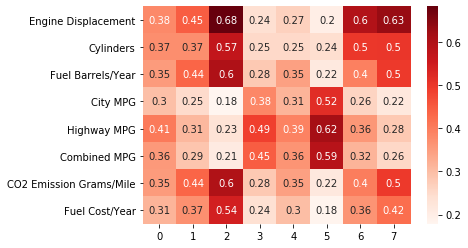

In [0]:
sns.heatmap(cluster_summary[cluster_columns].transpose(), cmap="Reds", annot=True)

Apakah yang dapat Anda analisis dari visualisasi di atas? Jika kesulitan dalam menganalisis mari kita clustering data ke jumlah yang lebih sedikit, misal 4 cluster.

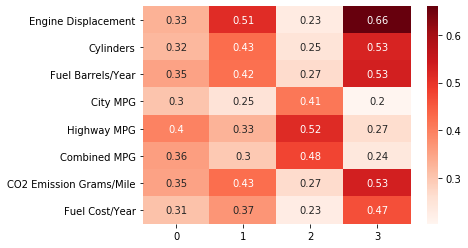

In [0]:
cluster_results = kmeans_cluster(vehicle_clusters, 4)
cluster_summary = summarize_clustering(cluster_results)

sns.heatmap(cluster_summary[cluster_columns].transpose(), cmap="Reds", annot=True)

##Langkah 4 - Data Interpretation

Untuk memahami hasil clustering, mari kita tambahkan deskripsi terkait dengan karakteristik yang dimiliki oleh tiap cluster. Dalam hal ini yang perlu kita perhatikan adalah nilai rata-rata yang terkandung dalam tiap kolom. Selanjutnya kita juga bisa memberikan label untuk memudahkan penjelasan deskripsi cluster tersebut.

*   **Cluster 3**: merupakan kumpulan kendaraan yang memiliki mesin berukuran besar (engine displacement dan cylinders tertinggi), membutuhkan banyak bahan bakar (fuel barrel/year), namun bekerja dengan tidak efisien (City, Highway, dan Combined MPG yang rendah) dan membutuhkan biaya yang besar dalam pengoperasiannya (Fuel Cost/Year yang cukup tinggi). Sehingga cluster ini dapat diberi label sebagai kelompok kendaraan yang ***Sangat Tidak Efisien***.
*   **Cluster 2**: merupakan kelompok kendaraan yang memiliki mesin kecil, hemat bahan bakar yang tidak menghasilkan banyak emisi dan relatif tidak mahal untuk diisi. Sehingga cluster dapat diberi label sebagai cluster yang ***Sangat Efisien***. 
*   Cluster 1: merupakan kumpulan kendaraan yang memiliki mesin besar tetapi lebih efisien daripada kendaraan di Cluster 3. Sehingga cluster ini dapat diberi label sebagai ***Cukup Tidak Efisien***.
*   Cluster 0: merupakan kumpulan kendaraan yang cukup seimbang untuk tiap atribut sehingga bisa diberi label sebagai cluster yang ***Cukup Efisien***.


#Referensi
[1] Prasad Patil, https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

[2] District Data Labs, https://medium.com/district-data-labs/data-exploration-with-python-part-1-643fda933479